In [465]:
import pygsti
from scipy.linalg import expm
import numpy as np
from pygsti.tools import unitary_to_superop
from pygsti.modelpacks import smq1Q_XYZI
from matplotlib import pyplot as plt
from pygsti.circuits import Circuit
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _rpeQ
from tqdm import tqdm
from importlib import reload
import kalman_rpe as _krpe
import kalman_filters as _filters

In [466]:
SIGX = pygsti.tools.sigmax
SIGY = pygsti.tools.sigmay
SIGZ = pygsti.tools.sigmaz
SIGM = np.array([[0, 1], [0, 0]])
SIGP = np.array([[0, 0], [1, 0]])

In [467]:
reload(_krpe)
reload(_filters)

<module 'kalman_filters' from '/home/jpmarceaux/VSProjects/KalmanRPE/kalman_filters.py'>

In [468]:
def make_dephasing_generator():
    return 0.5*(np.kron(SIGZ, SIGZ) - np.eye(4))

def make_decay_generator():
    return (np.kron(np.transpose(SIGP), SIGM) - 
            0.5*(np.kron(np.eye(2), SIGP@SIGM) + np.kron(np.transpose(SIGP@SIGM), np.eye(2))))

def make_unitary_generator(P):
    return (1j/2)*(np.kron(np.eye(2), P) - np.kron(np.conj(P), np.eye(2)))

In [469]:
make_dephasing_generator()

array([[ 0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [470]:
make_decay_generator()

array([[ 0. ,  0. ,  0. ,  1. ],
       [ 0. , -0.5,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  0. ],
       [ 0. ,  0. ,  0. , -1. ]])

In [471]:
make_unitary_generator(SIGX)

array([[ 0.+0.j ,  0.+0.5j, -0.-0.5j,  0.+0.j ],
       [ 0.+0.5j,  0.+0.j ,  0.+0.j , -0.-0.5j],
       [-0.-0.5j,  0.+0.j ,  0.+0.j ,  0.+0.5j],
       [ 0.+0.j , -0.-0.5j,  0.+0.5j,  0.+0.j ]])

In [472]:
def make_model_process_matrix(theta, L1, Lphi):
    unitary_gen = make_unitary_generator(SIGX)
    dephasing_gen = make_dephasing_generator()
    decay_gen = make_decay_generator()
    return expm((theta+np.pi/2)*unitary_gen + L1*dephasing_gen + Lphi*decay_gen)

def change_basis_to_pauli_transfer(op):
    pmats = [np.eye(2), SIGX, SIGY, SIGZ]
    op_ptransfer = np.zeros((4, 4), dtype=complex)
    for i in range(4):
        for j in range(4):
            op_ptransfer[i, j] = (1/2)*pmats[i].T.flatten()@op@pmats[j].flatten()
    return op_ptransfer.real

TARGET_PMAT = make_model_process_matrix(0, 0, 0)

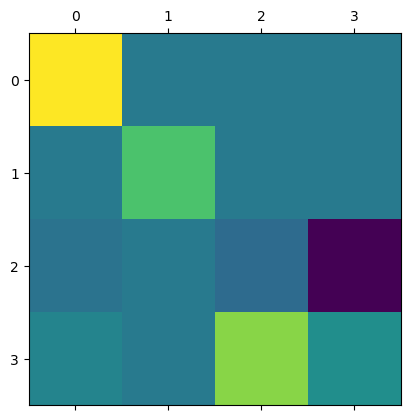

In [473]:
plt.matshow(change_basis_to_pauli_transfer(make_model_process_matrix(0, 0.6, 0.1)))

In [474]:
def process_fidelity(A):
    return np.trace(A@np.linalg.inv(TARGET_PMAT))/4

In [475]:
process_fidelity(make_model_process_matrix(0.1, 0.001, 0.01))

(0.9920428475581536+0j)

In [476]:
def probability(xstate, d, prep, meas):
    pmat = make_model_process_matrix(*xstate)
    rpe_op = np.linalg.matrix_power(pmat, 4*d)
    p = meas@rpe_op@prep
    assert p.imag < 1e-10
    return p.real

def dprob(xstate, d, prep, meas, epsilon=1e-6):
    grads = []
    for i in range(3):
        xstate_p = xstate.copy()
        xstate_m = xstate.copy()
        xstate_p[i] += epsilon
        xstate_m[i] -= epsilon
        grads.append((probability(xstate_p, d, prep, meas) - probability(xstate_m, d, prep, meas))/(2*epsilon))
    return np.array(grads)

def rpe_probabilities(xstate, circ_defs):
    pvec = np.zeros(len(circ_defs))
    for idx, (d_i, prep_i, meas_i) in enumerate(circ_defs):
        pvec[idx] = probability(xstate, d_i, prep_i, meas_i)
    return pvec

def rpe_grads(xstate, circ_defs):
    gvec = np.zeros((len(circ_defs), 3))
    for idx, (d_i, prep_i, meas_i) in enumerate(circ_defs):
        gvec[idx, :] = dprob(xstate, d_i, prep_i, meas_i)
    return gvec

def rpe_observation(xstate, circ_defs, num_shots):
    pvec = rpe_probabilities(xstate, circ_defs)
    return np.random.binomial(num_shots, pvec)


In [477]:
def step_xstate(xstate, q):
    return xstate + np.array([np.random.normal(0, q), 0, 0])

def make_xstate_timseries(xstart, q, num_steps):
    xstates = [xstart]
    x = xstart.copy()
    for i in range(num_steps-1):
        x = step_xstate(x, q)
        xstates.append(x)
    return np.array(xstates)

In [478]:
import kalman_filters as _filters
reload(_filters)



<module 'kalman_filters' from '/home/jpmarceaux/VSProjects/KalmanRPE/kalman_filters.py'>

In [479]:
class MyEKF:
    def __init__(self, x, P, num_circs, save_history=False, dt=1, hx=None, fx=None):
        self.x = x
        self.P = P
        num_params = len(x)
        self.dt=1
        if save_history:
            self.xhistory = [x.copy()]
            self.Phistory = [P.copy()]
            self.store_history = True

    def fx(self, x, dt, u=None):
        if u is None:
            u = np.zeros(len(x))
        return x + u

    def hx(self, x, circ_defs, data_format="cartesian"):
        pvec = rpe_probabilities(x, circ_defs)
        return format_observation(pvec, data_format)

    def update(self, counts, num_shots_per_circuit, circ_defs, data_format="cartesian"):
        z = format_observation(counts/num_shots_per_circuit, data_format)
        R = (0.25/num_shots_per_circuit)*np.eye(len(circ_defs))
        H = rpe_grads(self.x, circ_defs)
        K = self.P@H.T@np.linalg.inv(H@self.P@H.T + R)
        self.x = self.x + K@(z - rpe_probabilities(self.x, circ_defs))
        self.P = self.P - K@H@self.P
        if self.x[1] < 0:
            self.x[1] = 0
        if self.x[2] < 0:
            self.x[2] = 0
        if self.store_history:
            self.xhistory.append(self.x)
            self.Phistory.append(self.P)

In [480]:
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints, SimplexSigmaPoints, JulierSigmaPoints
from filterpy.kalman import unscented_transform
from copy import deepcopy
from kalman_filters import format_observation
from numpy import dot



class LindbladUKF_3Param(UnscentedKalmanFilter):
    def __init__(self, x, P, num_circs, save_history=False, dt=1, hx=None, fx=None, points=None):
        num_params = len(x)
        self.dt=1
        self.points = JulierSigmaPoints(num_params, kappa=0)
        super().__init__(num_params, num_circs, dt=1, hx=self.hx, fx=self.fx, points=self.points)
        self.x = x
        self.P = P
        
        
        if save_history:
            self.xhistory = [x.copy()]
            self.Phistory = [P.copy()]
            self.store_history = True

        #self.points = MerweScaledSigmaPoints(num_params, alpha=1e-3, beta=2, kappa=0)
        
        #self.points = SimplexSigmaPoints(num_params, alpha=1)
        
    def fx(self, x, dt, u=None):
        if u is None:
            u = np.zeros(len(x))
        if x[1] < 0:
            x = x.copy()
            x[1] = 0
        if x[2] < 0:
            x = x.copy()
            x[2] = 0
        return x + u

    def hx(self, x, circ_defs, data_format="cartesian"):
        assert x[1] >= 0 and x[2] >= 0
        pvec = rpe_probabilities(x, circ_defs)
        return format_observation(pvec, data_format)

    def check_consistency_at_d(self, d):
        """Check that the experiment design at depth d is consistent for the sigma points."""
        pass
        
    def compute_process_sigmas(self, dt, fx=None, **fx_args):
        """
        computes the values of sigmas_f. Normally a user would not call
        this, but it is useful if you need to call update more than once
        between calls to predict (to update for multiple simultaneous
        measurements), so the sigmas correctly reflect the updated state
        x, P.
        """

        if fx is None:
            fx = self.fx

        # calculate sigma points for given mean and covariance
        sigmas = self.points_fn.sigma_points(self.x, self.P)

        for i, s in enumerate(sigmas):
            self.sigmas_f[i] = fx(s, dt, **fx_args)

    def predict(self, dt=None, UT=None, fx=None, **fx_args):
        """
        Performs the predict step of the UKF. On return, self.x and
        self.P contain the predicted state (x) and covariance (P). '

        Important: this MUST be called before update() is called for the first
        time.

        Parameters
        ----------

        dt : double, optional
            If specified, the time step to be used for this prediction.
            self._dt is used if this is not provided.

        fx : callable f(x, dt, **fx_args), optional
            State transition function. If not provided, the default
            function passed in during construction will be used.

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work - you can use x_mean_fn and z_mean_fn to alter the behavior
            of the unscented transform.

        **fx_args : keyword arguments
            optional keyword arguments to be passed into f(x).
        """

        if dt is None:
            dt = self._dt

        if UT is None:
            UT = unscented_transform

        # calculate sigma points for given mean and covariance
        self.compute_process_sigmas(dt, fx, **fx_args)

        #and pass sigmas through the unscented transform to compute prior
        _, self.P = UT(self.sigmas_f, self.Wm, self.Wc, self.Q,
                            self.x_mean, self.residual_x)

        # update sigma points to reflect the new variance of the points
        #self.sigmas_f = self.points_fn.sigma_points(self.x, self.P)
        self.compute_process_sigmas(0, fx, **fx_args)


        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

    def update(self, observation, num_shots_per_circuit, circ_defs, UT=None, hx=None, data_format="cartesian"):
        """
        Update the UKF with the given measurements. On return,
        self.x and self.P contain the new mean and covariance of the filter.

        update one generation at a time

        Parameters
        ----------

        observation: emperical distribution

        d: int, depth of the circuit

        num_shots: int, number of shots per circuit

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work - you can use x_mean_fn and z_mean_fn to alter the behavior
            of the unscented transform.

        hx : callable h(x, **hx_args), optional
            Measurement function. If not provided, the default
            function passed in during construction will be used.

        **hx_args : keyword argument
            arguments to be passed into h(x) after x -> h(x, **hx_args)
        """


        if hx is None:
            hx = self.hx

        if UT is None:
            UT = unscented_transform

        # elif isscalar(R):
        #     R = eye(self._dim_z) * R
        
        z = format_observation(observation/num_shots_per_circuit, data_format)
        #alpha_vec = (counts + np.ones(len(counts)))/(num_shots + len(counts)) Uncomment for Dirichlet covar
        #R = np.diag(alpha_vec*(1-alpha_vec)/(num_shots + len(counts) +1))
        R = (0.25/num_shots_per_circuit)*np.eye(len(circ_defs))
        # pass prior sigmas through h(x) to get measurement sigmas
        # the shape of sigmas_h will vary if the shape of z varies, so
        # recreate each time
        sigmas_h = []
        for s in self.sigmas_f:
            sigmas_h.append(hx(s, circ_defs, data_format=data_format))
        self.sigmas_h = np.atleast_2d(sigmas_h)

        # mean and covariance of prediction passed through unscented transform
        zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
        self.SI = self.inv(self.S)

        # compute cross variance of the state and the measurements
        Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
        
        # DEBUG
        #print(self.sigmas_f, self.sigmas_h)
        #print(np.linalg.norm(Pxz), np.linalg.norm(self.S), np.linalg.norm(self.SI))

        self.K = dot(Pxz, self.SI)        # Kalman gain
        self.y = self.residual_z(z, zp)   # residual

        x_new = self.x + dot(self.K, self.y)
        # phase unwrapping on x[2]
        # x_new[2] = np.unwrap([x_new[2]])
        # if np.linalg.norm(x_new - self.x) < tol:
        #     break
        # else:
        #     self.x = x_new
        #     self.compute_process_sigmas(self.dt, self.fx)
        #     #if i == max_iter - 1:
        #     #    print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
        self.x = x_new
        if self.x[1] < 0:
            self.x[1] = 0
        if self.x[2] < 0:
            self.x[2] = 0
        self.P = self.P - self.K@self.S@self.K.T

        # save measurement and posterior state
        self.x_post = self.x.copy()
        self.z = deepcopy(z)
        self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

        if self.store_history:
            self.xhistory.append(self.x)
            self.Phistory.append(self.P)

In [481]:
MEAS_0 = (0.5*np.eye(2) + 0.5*SIGZ).flatten()
MEAS_PLUS = (0.5*np.eye(2) + 0.5*SIGX).flatten()
MEAS_RIGHT = (0.5*np.eye(2) - 0.5*SIGY).flatten()

PREP_0 = (0.5*np.eye(2) + 0.5*SIGZ).flatten()
PREP_PLUS = (0.5*np.eye(2) + 0.5*SIGX).flatten()
PREP_RIGHT = (0.5*np.eye(2) + 0.5*SIGY).flatten()

def make_standard_experiment_at_depth(d):
    return [
        (d, PREP_0, MEAS_0),
        (d, PREP_0, MEAS_RIGHT),
        (d, PREP_PLUS, MEAS_PLUS),
    ]

In [482]:
xstate = np.array([0.1, 0.001, 0.01])
q = 0.001
num_steps = 1000
true_x_traj = make_xstate_timseries(xstate, q, num_steps)

In [483]:
def plot_estimate_trajectories(trajectories, uncertainties=None, labels=None):
    # plot 3 params over time
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))
    if uncertainties is None:
        uncertainties = [None]*len(trajectories)
    if labels is None:
        labels = [None]*len(trajectories)
    for i in range(3):
        for traj, uncert, label in zip(trajectories, uncertainties, labels):
            ax[i].plot(traj[:, i], label=label)
            if uncert is not None:
                ax[i].fill_between(np.arange(len(traj[:, i])), traj[:, i] - uncert[:, i], traj[:, i] + uncert[:, i], alpha=0.5)
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel(f"Parameter {i}")
        ax[i].legend()
    plt.show()

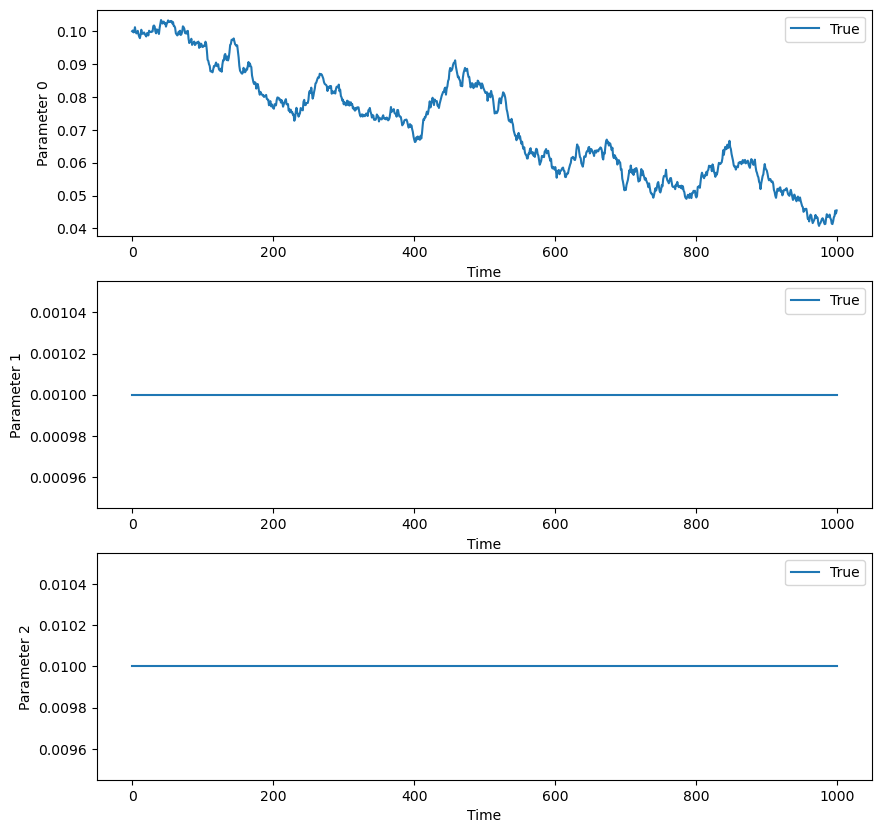

In [484]:
plot_estimate_trajectories([true_x_traj], None, ['True'])

In [485]:
def make_experiment_timeseries(xstates, circ_defs):
    """
    Generate a timeseries of experiments given a timeseries of xstates.
    rasterize the xstates into experiments.
    """
    assert len(xstates)%len(circ_defs) == 0
    


In [486]:
experiment_list = [make_standard_experiment_at_depth(d) for d in range(1, 10)]

In [487]:
def depth_function(P, idx):
    return 2**(idx // 500)

In [488]:
num_shots_per_circuit = 1

x0 = np.array([0, 0.001, 0.001])
P0 = np.diag([0.01, 1e-4, 1e-4])
Q = np.diag([q, 0, 0])

ukf = LindbladUKF_3Param(x0, P0, 3, save_history=True)
ukf.Q = Q

ekf = MyEKF(x0, P0, 1, save_history=True)
ekf.Q = Q

itr = 0
progress_bar = tqdm(total=len(true_x_traj))
while (itr < len(true_x_traj)):
    for sidx in range(num_shots_per_circuit):
        if itr >= len(true_x_traj) or itr + 3 > len(true_x_traj):
            itr = len(true_x_traj) # to break the while loop
            break
        for cidx in range(3):
            d = depth_function(P0, itr)
            circs = make_standard_experiment_at_depth(d)
            counts = rpe_observation(true_x_traj[itr], circs, 1)
            ukf.predict()
            ukf.update(counts, 1, circs)
            ekf.update(counts, 1, circs)
            itr += 1
            progress_bar.update(1)
progress_bar.close()


100%|█████████▉| 999/1000 [00:13<00:00, 76.66it/s]


In [502]:
def format_covar_error_bars(Phistory, num_sigma=1):
    Phistory = np.array(Phistory)
    error_bars = np.zeros((len(Phistory), 3))
    for i in range(3):
        error_bars[:, i] = num_sigma*np.sqrt(Phistory[:, i, i])
    return error_bars

In [503]:


def plot_depth_history(depth_history):
    plt.plot(depth_history)
    plt.xlabel("Time")
    plt.ylabel("Depth")
    plt.show()

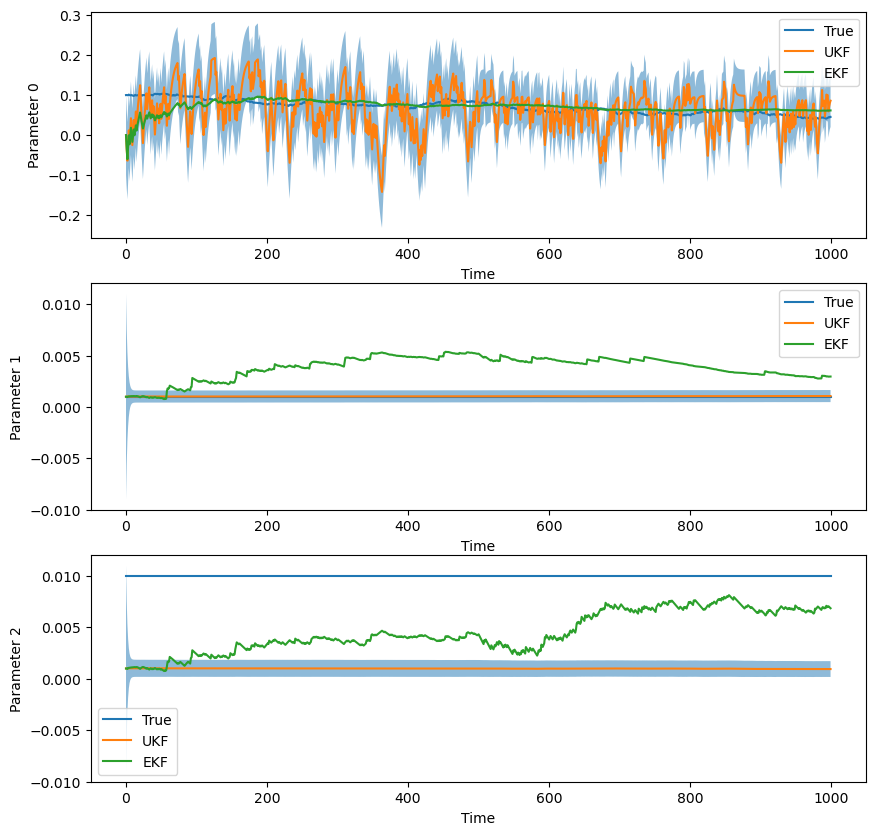

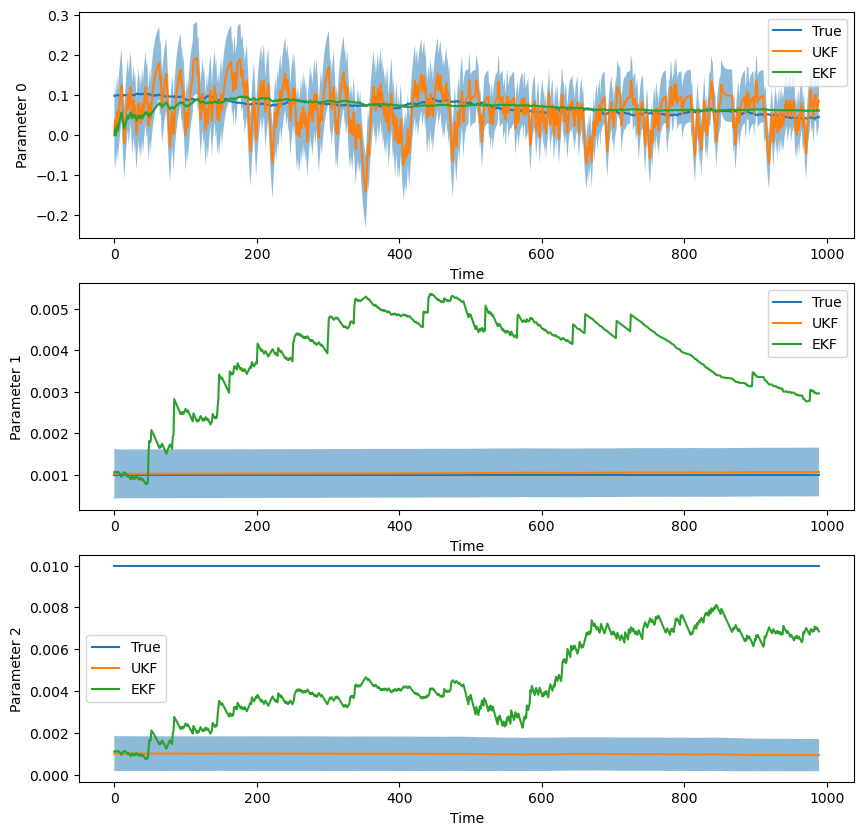

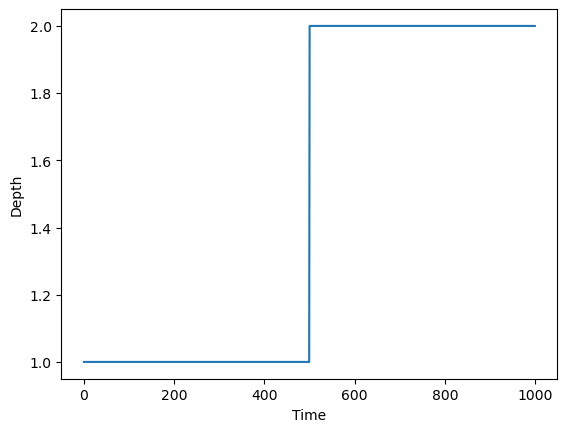

In [504]:
ukf_error_bars = format_covar_error_bars(ukf.Phistory)
depth_history = [depth_function(P0, idx) for idx in range(num_steps)]
plot_estimate_trajectories([true_x_traj, np.array(ukf.xhistory), np.array(ekf.xhistory)], [None, ukf_error_bars, None], ['True', 'UKF', 'EKF'])
second_start_idx = 10
plot_estimate_trajectories([true_x_traj[second_start_idx:], np.array(ukf.xhistory[second_start_idx:]), np.array(ekf.xhistory[second_start_idx:])], [None, ukf_error_bars[second_start_idx:], None], ['True', 'UKF', 'EKF'])
plot_depth_history(depth_history)

# scratch 

-----

In [492]:
state_preps = np.array([
    (0.5*np.eye(2) + 0.5*SIGZ).flatten(), 
    (0.5*np.eye(2) - 0.5*SIGZ).flatten(), 
    (0.5*np.eye(2) + 0.5*SIGX).flatten(), 
    (0.5*np.eye(2) - 0.5*SIGX).flatten(), 
    (0.5*np.eye(2) + 0.5*SIGY).flatten(), 
    (0.5*np.eye(2) - 0.5*SIGY).flatten()
])

measurements = np.conj(state_preps)

In [493]:
prep0 = state_preps[0]
prep_plus = state_preps[2]
prep_right = state_preps[4]
prep1 = state_preps[1]
meas0 = measurements[0]
meas_plus = measurements[2]
meas_right = measurements[4]

In [494]:
xtarget = np.array([0., 0., 0.])
xexample = np.array([0.1, 0.001, 0.01])
H_0_0 = dprob(xtarget, 1, prep0, meas0)
H_right_0 = dprob(xtarget, 1, prep_right, meas0)
H3 = dprob(xtarget, 1, prep_plus, meas_plus)
H = np.vstack([H_0_0, H_right_0, H3])

In [495]:
print(H)

[[ 5.55111512e-11 -1.00000000e+00 -1.50000000e+00]
 [ 2.00000000e+00  2.77555756e-11  8.32667268e-11]
 [ 0.00000000e+00 -2.00000000e+00 -1.00000000e+00]]


In [496]:
np.linalg.matrix_rank(H)

3

In [497]:

def make_all_dprobs(xstate, d):
    all_dprobs = [
        dprob(xstate, d, prep0, meas0),
        dprob(xstate, d, prep_plus, meas0),
        dprob(xstate, d, prep_right, meas0),
        dprob(xstate, d, prep0, meas_plus),
        dprob(xstate, d, prep_plus, meas_plus),
        dprob(xstate, d, prep_right, meas_plus),
        dprob(xstate, d, prep0, meas_right),
        dprob(xstate, d, prep_plus, meas_right),
        dprob(xstate, d, prep_right, meas_right)
    ]
    return np.vstack(all_dprobs)

In [498]:
make_all_dprobs(xtarget, 1)

array([[ 5.55111512e-11, -1.00000000e+00, -1.50000000e+00],
       [-5.55111512e-11, -2.77555756e-11, -1.11022302e-10],
       [ 2.00000000e+00,  2.77555756e-11,  8.32667268e-11],
       [-5.55111512e-11, -2.77555756e-11, -1.11022302e-10],
       [ 0.00000000e+00, -2.00000000e+00, -1.00000000e+00],
       [-5.55111512e-11, -2.77555756e-11, -1.11022302e-10],
       [-2.00000000e+00, -1.11022302e-10, -3.33066907e-10],
       [-5.55111512e-11, -5.55111512e-11, -1.11022302e-10],
       [ 1.11022302e-10, -1.00000000e+00, -1.50000000e+00]])

In [499]:
dprob(xtarget, 19, np.array([0.5, 0, 0, 0.5]), meas0)

array([-6.38378239e-10, -6.93889390e-10, -2.77555756e-09])

In [500]:
prep0

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [501]:
np.eye(2).flatten()

array([1., 0., 0., 1.])